### import

In [ ]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from transformers import CLIPProcessor, CLIPModel
import open_clip


# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

/Users/zirong/miniforge3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.5.1
Transformers version: 4.47.0
Accelerate version: 0.26.0


### voice to text


In [8]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [5]:
from typing import Union  # 添加 Union 导入
from pathlib import Path

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [ ]:
%matplotlib inline
# from IPython.display import display, Image
class ClipEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224),
                ):
        """
        初始化: 建立clip_collection,使用CLIP(or OpenCLIP)做embedding
        """
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir) 
        
        # ====== 1) 初始化 CLIP ======
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        # 測試一下,取得image特徵維度(通常是512)
        with torch.no_grad():
            dummy = torch.zeros((1, 3, 224, 224))
            dim_out = self.clip_model.get_image_features(dummy).shape[1]
        self.clip_dim = dim_out

        # ====== 2) 建立Chroma,只做一個collection: clip_collection ======
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)

        # 先刪除舊的 collection(若存在)
        try:
            self.chroma_client.delete_collection("clip_collection")
        except:
            pass

        # 建立無embedding_function的collection,因為我們手動算embedding
        self.clip_collection = self.chroma_client.create_collection(
            name="clip_collection",
            metadata={"dimension": self.clip_dim}
        )
        print(f">> Created single 'clip_collection' in {persist_directory} with dimension={self.clip_dim}.")


    def process_text_with_clip(self, text: str) -> Optional[np.ndarray]:
        """
        用 CLIP 的 text encoder 將文字轉為512維向量
        """
        try:
            inputs = self.clip_processor(text=[text], return_tensors="pt", truncation=True)
            with torch.no_grad():
                text_feat = self.clip_model.get_text_features(**inputs)
            return text_feat.detach().cpu().numpy()[0]
        except Exception as e:
            print(f"Error in process_text_with_clip: {str(e)}")
            return None

    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                all_ids=[]
                all_embeddings=[]
                all_metadatas = []

                
                for i, (img_path,question_text) in enumerate(zip(images, questions)):
                    img_emb = self.process_image(str(self.image_dir / img_path))
                    txt_emb = self.process_text_with_clip(question_text)

                    if img_emb is not None:
                        all_embeddings.append(img_emb.tolist())
                        # img_embeddings_list = img_embeddings.tolist()
                        # all_metadatas.append(img_embeddings_list)
                        # valid_images.append(img_path)
                        all_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_question": question_text
                        })
                        all_ids.append(f"img_{i}")
                    if txt_emb is not None:
                        all_embeddings.append(txt_emb.tolist())  
                        all_metadatas.append({
                            "type": "clip_text", 
                            "text": question_text,
                            "related_image": img_path
                        })
                        all_ids.append(f"txt_{i}")

                if len(all_embeddings)>0:
                    logger.info(f"Adding {len(all_embeddings)} total embeddings to collection")
                    self.image_collection.add(
                        embeddings=all_embeddings,
                        metadatas=all_metadatas,
                        ids=all_ids
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image_with_clip(self, image_path: str) -> Optional[np.ndarray]:
            """
            用 CLIP image encoder 將圖片轉為512維向量
            """
            try:
                # 先做基礎處理,縮放或另存
                processed_path = self.image_processor.process_and_save(
                    image_path, self.image_size
                )
                if not processed_path:
                    return None

                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    img_feat = self.clip_model.get_image_features(**inputs)
                return img_feat.detach().cpu().numpy()[0]
            except Exception as e:
                print(f"Error in process_image_with_clip: {str(e)}")
                return None


    def add_data(self, 
                texts: Optional[List[str]] = None, 
                metadatas: Optional[List[Dict]] = None,
                images: Optional[List[str]] = None):
        """
        統一方法:把text or image加到 clip_collection
        你可以自行拆成add_text/add_image,或像這樣合併都行
        需確保 texts與metadatas數量相同, 或 images與metadatas數量相同(可依需求調整)
        """
        all_embeddings = []
        all_metadatas = []
        all_ids = []

        idx = 0

        if texts is None:
            texts = []
        if images is None:
            images = []
        if metadatas is None:
            metadatas = []

        # 1) 對文字做embedding
        if texts:
            for i, txt in enumerate(texts):
                emb = self.process_text_with_clip(txt)
                if emb is not None:
                    all_embeddings.append(emb.tolist())
                    # 若metadatas!=None且有對應,i則metadata[i],加上"type":"text"
                    md = {"type":"text","content":txt}
                    if metadatas and i < len(metadatas):
                        md.update(metadatas[i])  # 合併使用者自定屬性
                    all_metadatas.append(md)
                    all_ids.append(f"text_{idx}")
                    idx+=1

        # 2) 對圖片做embedding
        if images:
            for j, img_path in enumerate(images):
                full_path = str(self.image_dir / img_path)
                emb = self.process_image_with_clip(full_path)
                if emb is not None:
                    all_embeddings.append(emb.tolist())
                    md = {"type":"image","path":img_path}
                    if metadatas and j < len(metadatas):
                        md.update(metadatas[j])
                    all_metadatas.append(md)
                    all_ids.append(f"img_{idx}")
                    idx+=1

        # 3) 寫入 clip_collection
        if len(all_embeddings) > 0:
            self.clip_collection.add(
                embeddings = all_embeddings,
                metadatas = all_metadatas,
                ids = all_ids
            )
            print(f"Added {len(all_embeddings)} items to 'clip_collection'.")


    def search(self, query: str, k=3) -> Dict:
        """
        對query做CLIP text embedding後,在clip_collection裡找最相似的k筆
        """
        try:
            emb = self.process_text_with_clip(query)
            if emb is None:
                return {"metadatas":[],"documents":[],"distances":[],"ids":[]}

            results = self.clip_collection.query(
                query_embeddings=[emb],
                n_results=k
            )
            # results一般會包含: {"metadatas":[[]], "documents":[[]], "distances":[[]], "ids":[[]]}
            # 這裡可視情況進一步整理

            # 1) 檢索專業
            # prof_result = self.clip_collection.query(
            #     query_embeddings=[emb],
            #     where={"type": "professional"},  # 只要metadata裡 'type' = 'professional'
            #     n_results=2
            # )

            # # 2) 檢索全部
            # all_result = self.clip_collection.query(
            #     query_embeddings=[emb],
            #     n_results=3
            # )

            # # 把兩組 metadata/distances合併(視需求去重)
            # final_chunks = combine(prof_result, all_result)

            return results
        except Exception as e:
            print(f"Error in search: {str(e)}")
            return {"metadatas":[],"documents":[],"distances":[],"ids":[]}

### 資料處理模組

In [ ]:
class DataProcessor:
    def __init__(self, embedding_processor: 'ClipEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_excel(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses),
                            'link': current_link if current_link else ''
                        }
                    }
                    if pd.notna(row.get('image_description')):
                        qa_pair['metadata']['image_desc'] = row['image_description']

                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
  
        
        # 保存最后一个问答对
        if current_post is not None and len(current_responses) >= 3:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses),
                    'link': current_link if current_link else ''
                }
            }
            if pd.notna(row.get('image_description')):
                    qa_pair['metadata']['image_desc'] = row['image_description']

            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    
    def chunk_text(paragraph: str, chunk_size: int = 300, overlap: int = 50) -> List[str]:
        """
        將給定段落，以 chunk_size 字符為上限進行切分，並且在 chunk 之間保留 overlap 個字的重疊，
        以免上下文斷裂。
        備註: 
        - 這裡以「字符」為單位，適合中文；英文也可用，但若想精確對英文 tokens 可改更先進方法。
        """
        chunks = []
        start = 0
        length = len(paragraph)

        # 去掉前後多餘空白
        paragraph = paragraph.strip()

        while start < length:
            end = start + chunk_size
            # 取 substring
            chunk = paragraph[start:end]
            chunks.append(chunk)
            # 移動指標(下一個 chunk)
            # overlap 預防斷句失去上下文
            start += (chunk_size - overlap)

        return chunks


    def process_pdf(self, pdf_path: str) -> List[Dict]:
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    # 處理每個段落
                    for para in paragraphs:

                        para_chunks = self.chunk_text(para, chunk_size=300, overlap=50)

                        for c in para_chunks:
                            qa_pair = {
                                'question': c[:50] + "...",  
                                'answers': [c],
                                'metadata': {
                                    'type': 'professional',
                                    'source_file': pdf_name,  # 添加文件名
                                    'page': str(page_num + 1),
                                    'content_length': str(len(c))
                                }
                            }
                            professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """綜合處理社群 CSV + PDFs"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path(self.embedding_processor.image_dir) / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并 => all_qa_pairs
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 準備 texts + metadatas => 你就能一次或多次呼叫 add_data
            questions = []
            answers = []
            question_metas = []
            answer_metas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                # question 
                questions.append(qa_pair['question'])
                question_metas.append(qa_pair['metadata'])
                
                # answers
                for ans_text in qa_pair['answers']:
                    answers.append(ans_text)
                    am = qa_pair['metadata'].copy()
                    am['parent_question'] = qa_pair['question']
                    answer_metas.append(am)
            
            # 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 5. 全部寫進clip_collection
            # (A) 先加所有 question
            self.embedding_processor.add_data(
                texts = questions,
                metadatas = question_metas
            )

            # (B) 再加所有 answers
            self.embedding_processor.add_data(
                texts = answers,
                metadatas = answer_metas
            )
            # (C) 再加 images
            # 沒有對應metadata？可以簡單做
            # [{"type":"image","source":"facebook"} ...] 或
            # 想知道它屬於哪個QApair? 就要自己對應
            if valid_images:
                meta_for_imgs = []
                for img_name in valid_images:
                    meta_for_imgs.append({
                        "type":"image",
                        "source":"facebook",
                        "filename": img_name
                    })

                self.embedding_processor.add_data(
                    images=valid_images,
                    metadatas=meta_for_imgs
                )

            logger.info("All data added to clip_collection.")
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise


### QA系統模組

##### code

In [7]:
class QASystem:
    def __init__(self, embedding_processor: 'ClipEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def _classify_collection_results(self, raw_result) -> Dict:
        """
        將 clip_collection 的檢索結果 (metadatas/documents...) 
        轉換成 { 'social': {...}, 'professional': {...}, 'images': {...} } 
        的結構，便於後續 gather_references / format_context。
        """
        # 預設空結構
        structured = {
            "social": {
                "metadata": [],
                "link": [],
                "content": []
                # 你也可以放 'documents':[], 'relevance':[]... 視需要
            },
            "professional": {
                "metadata": [],
                "content": []
                # ...
            },
            "images": {
                "metadata": [],
                "paths": [],
                "relevance":[]
            }
        }

        # raw_result["metadatas"] 是個 2D list => [ [meta0, meta1, ...] ]
        if raw_result.get("metadatas"):
            meta_list = raw_result["metadatas"][0]  # 因為只有1個 query
            dist_list = raw_result["distances"][0] if raw_result.get("distances") else []
            ids_list  = raw_result["ids"][0] if raw_result.get("ids") else []
            # documents_list = raw_result["documents"][0]

            for i, meta in enumerate(meta_list):
                dist = dist_list[i] if i < len(dist_list) else None
                doc_id = ids_list[i] if i < len(ids_list) else ""

                # 判斷 metadata 是屬於哪個來源
                # 例如 meta.get("type") == "social_qa" => 放到 social
                #     meta.get("type") == "professional" => 放到 professional
                #     meta.get("type") == "image" => 放到 images
                src_type = meta.get("type","")

                if src_type in ["social_qa"]:
                    # 純文字 chunk => 放social
                    structured["social"]["metadata"].append(meta)
                    # 若 meta 裡有 link => structured["social"]["link"].append(meta["link"])
                    link_str = meta.get("link","")
                    if link_str:
                        structured["social"]["link"].append(link_str)
                    # content or question
                    if "post_content" in meta:
                        structured["social"]["content"].append(meta["post_content"])

                elif src_type in ["professional"]:
                    structured["professional"]["metadata"].append(meta)
                    # 可能把段落文字塞到 "content"
                    # (這需要你當初 add_data 時有在 documents/metadata 寫 para)
                    # 這裡只是示例
                    # ...
                
                elif src_type == "image":
                    structured["images"]["metadata"].append(meta)
                    # 放 path
                    path = meta.get("path","")
                    structured["images"]["paths"].append(path)
                    structured["images"]["relevance"].append(dist)

                # 你也可以做 else: pass 之類

        return structured


    def determine_question_type(self, query: str) -> str:
        """判斷問題類型"""
        # 1. 選擇題：包含 A.B.C.D 或選項相關詞
        if any(char in query for char in ['A.', 'B.', 'C.', 'D.']) or any(keyword in query for keyword in ['何者', '下列', '哪一個', '哪種']):
            return "multiple_choice"
        
        # 2. 是非題：包含「是否」、「是嗎」等
        elif any(keyword in query for keyword in ['是否', '是嗎', '對嗎', '正確嗎']):
            return "true_false"
        
        # 3. 一般諮詢
        else:
            return "qa"

    def gather_references(self, search_results: Dict) -> str:
        """
        從 search_results 中擷取 PDF 檔名/社群連結，並組成一個字串
        """
        references = []

        # 處理 social
        for meta in search_results["social"].get("metadata", []):
            if meta.get("type") == "social_qa" and "link" in meta:
                references.append(f"(經驗) {meta['link']}")

        # 處理 professional
        for meta in search_results["professional"].get("metadata", []):
            if meta.get("type") in ["pdf", "professional"]:
                pdf_name = meta.get("source_file", "unknown.pdf")
                references.append(f"(文獻) {pdf_name}")

        # 去重
        unique_refs = list(set(references))
        return "\n".join(unique_refs)


    def get_prompt_by_type(self,query: str, context: str, question_type: str, references_str: str = "") -> str:
        
        # role
        base_system = (
            "您是一名專業獸醫，擅長：1.犬認知功能障礙綜合症（CCD）的診斷和護理 2.常見問題診斷及改善建議"
        )

        prompts = {
            "multiple_choice": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                    {base_system}
                                    <|eot_id|><|start_header_id|>user<|end_header_id|>
                        
                                    這是一題選擇題：{query}

                                    請以以下格式回答：
                                    1. 第一行只能回答 A/B/C/D (請勿帶任何標點、文字)
                                    2. 第二行才是說明，以 2~3 句話簡述理由
                                    3. 若同時出現多個選項，請只選一個最適合的
                                    4. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                    5.  若有相關圖片，在回答中自然地說明圖片內容跟回答的關係

                                    限制：
                                    - 請將整體回答限制在 200 字以內
                                    - 直接切入重點
                                    - 保持客觀和專業

                                    參考資料：
                                    {context}

                                    來源：
                                    {references_str}

                                    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                    """,
            "true_false": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 一定先指出「True」或「False」(僅能擇一)，若遇到無法確定或證據不足的情況，一律為False，並說明原因
                                2. 再以 2～3 句話說明原因
                                3. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                4.  若有相關圖片，在回答中自然地說明圖片內容跟回答的關係

                                限制：
                                - 請將整體回答限制在 200 字以內
                                - 直接切入重點
                                - 保持客觀和專業

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """,
            "qa": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 針對問題提供具體答案
                                2. 若遇到無法確定或證據不足的情況可以補充說明研究不足
                                3. 提供實用的建議或解釋
                                4. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                5. 若有相關圖片，在回答中說明圖片內容

                                限制：
                                - 請將整體回答限制在 400 字以內
                                - 使用平易近人的語言
                                - 避免過度技術性術語

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """
        }

        # 若 question_type 未包含在定義的 prompts 中，就預設使用 "qa"。
        return prompts.get(question_type, prompts["qa"])

    def generate_response(self, query: str) -> Tuple[str, List[str]]:
        try:
            raw_result = self.embedding_processor.search(query)  
            # raw_result 是 clip_collection 的資料
            # 用後處理
            # search_results = self.embedding_processor.search(raw_result)
            search_results = self._classify_collection_results(raw_result)
            logger.info("SEARCH RESULT(structured): %s",search_results)


            context = self.format_context(search_results)
            references_str = self.gather_references(search_results)
            # link應該用傳參數的會成功 可能用context.link之類的抓題目的reference
            question_type = self.determine_question_type(query)
            prompt = self.get_prompt_by_type(query, context, question_type, references_str)
            message = {
                'role':'user',
                'content': prompt
            }

            # 處理圖片
            image_paths = []
            # 2) 從 social metadata 把圖片撈出
            for md in search_results["social"]["metadata"]:
                if md.get("images"):  # e.g. "image12.jpg,image02.jpg"
                    for img_name in md["images"].split(","):
                        img_name = img_name.strip()
                        if img_name:
                            full_path = self.embedding_processor.image_dir / img_name
                            if full_path.exists():
                                image_paths.append(str(full_path.resolve()))
            # 3) OLlama 只允許一張, 你可取 image_paths[:1] => message["images"] = ...
            if image_paths:
                print("We found images: ", image_paths)
                # 你可以先隨便取一張
                # or 全部 inject to prompt
            else:
                logger.info("No images to display")

            # 生成响应
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )
            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            return f"出現問題，檢查ollama連線或是generate_response", []

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""

            if search_results.get("social"):
                context += "\n[社群討論]\n"
                question_s = search_results["social"].get("link", [])
                metadata_s = search_results["social"].get("metadata", [])
                for q, meta in zip(question_s, metadata_s):
                    context += f"標題：{q}\n"
                    if "link" in meta:
                        context += f"link: {meta['link']}\n\n"

            if search_results.get("professional"):
                context += "\n[專業文獻]\n"
                c_p = search_results["professional"].get("content", [])
                metadata_p = search_results["social"].get("metadata", [])
                for cp,mp in zip(c_p,metadata_p):
                    context += f"{cp}\n\n"
                    if "source_file" in mp:
                        context += f"title: {meta['source_file']}\n\n"
                    
            print("social metadata:", search_results["social"].get("metadata", []))
            print("social link:", search_results["social"].get("link", []))

            print("professional metadata:", search_results["professional"].get("metadata", []))
            
            return context if context.strip() else "參考資料無法取得"
                
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"
 


    def display_response(self, query: str):
            """Display response with text and images"""
            try:
                logger.info("Starting to generate response...")

                response_text, image_paths = self.generate_response(query)
                
                print("Question:", query)
                print("\nSystem Response:")
                print(response_text)
                print("\n" + "-"*50 + "\n")

                if image_paths:
                    print("\nRelated Image:")
                    img_path = image_paths[0]  # We now only have one image
                    try:
                        img = PILImage.open(img_path)
                        display(IPyImage(filename=img_path))
                    except Exception as e:
                        logger.error(f"Error displaying image {img_path}: {str(e)}")
                else:
                    logger.info("No images to display")


                return response_text, image_paths # add for response 0406
                    
            except Exception as e:
                logger.error(f"Error in display_response: {str(e)}", exc_info=True)  
                return "", [] 

### 系統初始化和資料處理

In [8]:
from pathlib import Path

# 初始化 embedding processor
embedding_processor = ClipEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

# 自動抓取 RAG_data 資料夾中的所有 PDF 檔案
rag_data_dir = Path("RAG_data")
pdf_paths = list(rag_data_dir.glob("*.pdf"))

# 輸出找到的檔案清單（可選）
print(f"找到以下 PDF 檔案：")
for pdf in pdf_paths:
    print(f"  - {pdf}")

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response_filtered.xlsx",#"post_response_v2.csv"
    pdf_paths=pdf_paths
)

INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:__main__:Processing CSV: post_response_filtered.xlsx


>> Created single 'clip_collection' in chroma_db with dimension=512.
找到以下 PDF 檔案：
  - RAG_data/Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf
  - RAG_data/Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf
  - RAG_data/Journal of Neuroimmunology.pdf
  - RAG_data/Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf
  - RAG_data/The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf
  - RAG_data/Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf
  - RAG_data/Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf


INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post
INFO:__main__:Found image: image05.jpg for current post
INFO:__main__:Found image: image06.jpg for current post
INFO:__main__:Found image: image07.jpg for current post
INFO:__main__:Found image: image08.jpg for current post
INFO:__main__:Found image: https://i.redd.it/1q4ifdj92jt81.jpg for current post
INFO:__main__:Found image: image09.jpg for current post
INFO:__main__:Found image: image10.jpg for current post
INFO:__main__:Found image: image11.jpg for current post
INFO:__main__:Found image: image12.jpg for current post
INFO:__main__:Found image: image13.jpg for current post
INFO:__main__:Found image: image14.jpg for current post
INFO:__main__:Found image: https://i.redd.it/hx3k6qpjg3h31.jpg for current post
INFO:__main__:Found image: https://i.redd.it/bgk1puts2uh

Added 711 items to 'clip_collection'.


INFO:__main__:Saved processed image to: image/image01.jpg
INFO:__main__:Saved processed image to: image/image02.jpg
INFO:__main__:Saved processed image to: image/image03.jpg
INFO:__main__:Saved processed image to: image/image04.jpg
INFO:__main__:Saved processed image to: image/image05.jpg


Added 3942 items to 'clip_collection'.


INFO:__main__:Saved processed image to: image/image06.jpg
INFO:__main__:Saved processed image to: image/image07.jpg
INFO:__main__:Saved processed image to: image/image08.jpg
INFO:__main__:Saved processed image to: image/image10.jpg
INFO:__main__:Saved processed image to: image/image11.jpg
INFO:__main__:Saved processed image to: image/image12.jpg
INFO:__main__:Saved processed image to: image/image13.jpg
INFO:__main__:Saved processed image to: image/image14.jpg
INFO:__main__:All data added to clip_collection.


Added 13 items to 'clip_collection'.


### 系統測試

In [11]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/19XTRfUdmd/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？有相關照片嗎？

System Response:
老狗的認知功能障礙，尤其是卡在角落或家具間的問題，是一種常見的情況。為了幫助牠們更舒適地生活，我們需要進行環境安排和居家照護措施。以下是一些建議：

1. **簡化空間**: 將家裡的傢俱和家具重新排列，以減少卡住的可能性。此外，將房子的門口設置為寬敞的通道，方便老狗自由行動。
2. **增加視覺提示**: 在牠們經常停留的地方設置清晰醒目的標記牌或方向指示牌，以幫助牠們辨識路徑和方向。
3. **改善照顧和溝通**: 確保老狗與家人保持良好的溝通，定期檢查牠們的認知功能，並及時反饋給獸醫進行評估。提供適當的照顧和活動，以促進其身體和精神健康。
4. **減少環境壓力**: 減少家裡的噪音和干擾，創造一種舒適、安靜的環境，有助於老狗放鬆身心。

其它飼主通常也會採取類似的措施，並且有些人還會在牠們的寢室或活動區域設置「導引地帶」，以幫助老狗更容易找到回家的路。還有一些人會使用輔助器具，如導航輪椅等，以協助老狗移動。

**相關照片**: 
* 一個老狗站在家裡的通道上，身邊有標記牌指示方向。
* 一個老狗坐在導引地帶中，有一根導航桿幫助牠們找到回家的路。
* 一個老狗乘坐導航輪椅，走在房子的走廊上。

參考資料：

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]
[Experience: https://www.facebook.com/share/p/1B7u3jFDy9/]

--------------------------------------------------


Related Image:


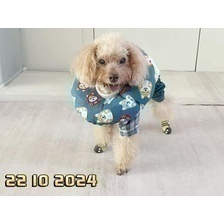

In [87]:
# 測試查詢
test_queries = [
# "CCD 是否與神經發炎相關？有無特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？",
# "CCD 是否與腸道微生物群變化有關？是否有特定細菌群落會影響大腦健康？",
# " 失智犬的松果體是否退化",
# " 有刻板形為的犬隻是否會增加CCD風險？",
# " 失智犬分泌褪黑激素的能力是否退化？",
# " 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？",
# " 如何區分正常老化與CCD的早期徵兆？ ",
# " B 群維生素是否能降低 CCD 進展風險？",
# " 食用GABA是否對於預防CCD有效？",
# " 警犬、救難犬等工作犬在罹患CCD的機率比較家庭陪伴犬",
# " 目前是否有影像學檢測可以準確區分 CCD 與其他神經退行性疾病？",
# " 如果CCD進展到最後階段，哪些症狀最需要關注？如何平衡狗狗的生活質量與疼痛管理，並且決定狗狗未來的方向",

# "根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？",
# "資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？",
# "在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？",
# "資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？",
# "針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。",

# "哪種犬容易失智？",
# "大中小型狗的失智照顧方式有什麼不同？"
# "我的狗狗有失智症，晚上總是繞圈圈而且叫個不停，有什麼方法能幫助牠安靜下來睡覺嗎？有人推薦過褪黑激素，這真的有效嗎？",
"我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？有相關照片嗎？",
# "給我一些照護環境的圖片"
                    ]

for query in test_queries:
    qa_system.display_response(query)


### TESTING

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2Fidyou

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.faceboo

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: CCD 是否與神經發炎相關？是否有特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？

System Response:
True

CCD（犬認知功能障礙綜合症）確實與神經發炎有關。研究表明，發炎反應在 CCD 的病理生理過程中扮演著重要角色。例如，NLRP3 inflammasome是一種結構，可以活化導致白三烷酸（IL-1β）的釋放，這可能與 CCD 的神經損傷和功能障礙相關。

研究表明，發炎反應與多個細胞因子參與，其中包括 IL-1β、TNF-α 和 IL-6 等。這些細胞因子可以促進神經損傷和功能障礙的發展。

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

--------------------------------------------------


Related Image:


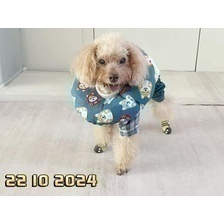

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['h

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: CCD 是否與腸道微生物群變化有關？哪些特定細菌群可能影響大腦健康？

System Response:
True

犬認知功能障礙綜合症（CCD）確實與腸道微生物群變化有關。研究表明，某些特定細菌群可能影響大腦健康。例如，研究發現某些犬隻的腸道中出現了一些新的致病性細菌，進而導致了神經退行性疾病。

這些細菌可能會干擾宿主的免疫系統和神經系統，從而引起一系列問題。因此，保持良好的腸健康是預防CCD的一個關鍵因素。

[Experience: https://www.facebook.com/share/p/1B7u3jFDy9/]

--------------------------------------------------


Related Image:


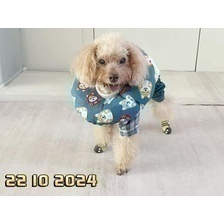

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/1B7u3jFDy9/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 失智犬的松果體是否退化？是否影響褪黑激素分泌？

System Response:
真實性：False

失智犬的松果體確實會退化，但這與褪黑激素分泌的直接影響不完全相同。松果體是負責生產多種神經內分泌激素，包括褪黑激素（Melatonin），但在犬類動物中，褪黑激素的分泌主要受到日間光照的調節，而不是由松果體直接控制。

因此，在失智犬中，褪黑激素的分泌可能會受損害，但這與松果體退化是相關但不同的問題。 [Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


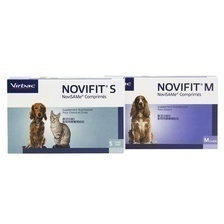

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count'

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: B 群維生素是否能降低 CCD 進展風險？

System Response:
False

目前沒有足夠的科學證據表明 B 群維生素能降低犬認知功能障礙綜合症 (CCD) 的進展風險。研究仍在進行中，需要更多的研究來確認這一假設。

一些研究人員根據個案報告和個體經驗提倡對 CCD 患者進行 B 群維生素的補充，但這些結果尚未得到廣泛接受或證實。

最終，我們需要基於可靠的科學文獻來確定 B 群維生素是否能夠降低 CCD 的進展風險。

--------------------------------------------------


Related Image:


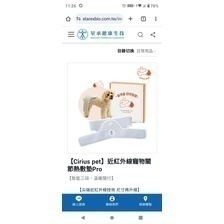

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2Fidyouqq

social metadata: [{'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 食用GABA 是否對於預防 CCD 有效？

System Response:
False

食用GABA（γ-氨基丁酸）與預防犬認知功能障礙綜合症（CCD）的直接關聯並未獲得實証。雖然一些研究表明GABA對於神經系統的調節有幫助，但目前仍無法確定它能夠有效預防或治療CCD。

在多數動物試驗中，GABA的效果與其使用方式、劑量以及個體差異都存在變化。然而，對於犬隻的臨床研究和實踐表明，GABA不一定能夠有效預防或治療CCD。

因此，我們應當繼續關注最新的科學證據，並保持謹慎與批判性思維來評估這類藥物的效果。

參考資料： [Experience: https://www.facebook.com/share/v/1A1RLmKiaw/]

--------------------------------------------------


Related Image:


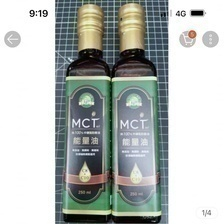

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 警犬、救難犬等工作犬在罹患CCD的機率是否比家庭陪伴犬較高？

System Response:
True

警犬、救難犬等工作犬罹患犬認知功能障礙綜合症（CCD）的機率可能較高，因為這類狗通常在年輕時期接受嚴格訓練和壓力，對其神經系統造成不當影響。同時，這些狗的生活方式也可能導致早發老化和身體負擔加重，加速了CCD的發展。

在工作犬中，研究表明長期暴露於高水平的壓力、訓練強度和缺乏充足休息時間等因素都可能增加患CCD的風險。[Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


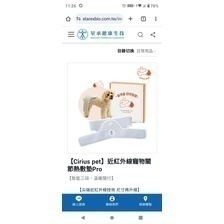

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 是否有影像檢測可準確區分 CCD 與其他神經退行性疾病？

System Response:
True

CCD（犬認知功能障礙綜合症）是一種複雜的神經退行性疾病，目前仍然無法通過單一影像檢測來準確區分它與其他類似的疾病。多個研究表明，電腦斷層掃描（CT）、磁共振成像（MRI）和功能性核磁共振成像（fMRI）等技術都可能被用於評估犬的神經系統，但這些方法仍然需要結合臨床表現、實驗室檢查和動物行為學評估來確定診斷。

在臨床實踐中，我們會根據個案的症狀、家族史和其他醫療信息，進行綜合評估。影像檢測可以提供額外的資訊，但不能獨立作出診斷。

[Experience: https://www.facebook.com/share/p/8wwZPppwzKkueWwv/]

--------------------------------------------------


Related Image:


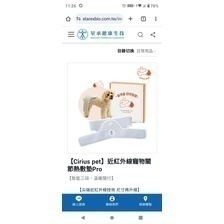

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖

social metadata: [{'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？

System Response:
True

皮質類固醇cortisol或應激荷爾蒙stress hormones確實可以作為犬認知功能障礙綜合症（CCD）的潛在診斷指標。研究表明，患有CCD的狗往往會出現調節內分泌系統的問題，例如皮質類固醇水平增高。這些荷爾蒙變化可能是由於長期應激反應、神經退行性疾病或其他因素導致。

根據研究結果顯示，一般而言，患有CCD的狗的皮質類固醇水平會比正常犬更高，並且這些荷爾蒙變化可能與認知功能障礙的程度相關。因此，檢測和監測皮質類固醇水平可以作為診斷和追蹤CCD的工具之一。

[Experience: https://www.facebook.com/share/p/8wwZPppwzKkueWwv/]

--------------------------------------------------


Related Image:


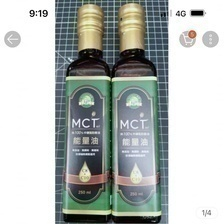

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.f

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/18X1KzFKzp/', 'https://

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 有刻板形為的犬隻是否會增加CCD風險？

System Response:
True

刻板形狀的犬隻可能會增加犬類認知功能障礙綜合症（CCD）的風險。這是因為某些特定品種犬隻，例如巴格爾犬和法國鬥牛犬，由於其特殊的外貌和遺傳基因結構，更容易患有 CCD。

研究顯示，這些犬隻可能具有較高的 CCRA1 基因突變率，而 CCRA1 是 CCD 的一個已知致病基因。 [Experience: https://www.facebook.com/share/p/1B7u3jFDy9/]

--------------------------------------------------


Related Image:


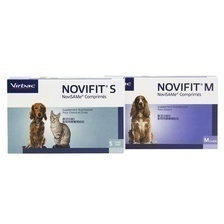

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 若家中老犬常在晚間吠叫、彷彿不安，以下哪項做法最優先？
A. 搬家讓牠換新環境
B. 夜間完全關燈並限制活動
C. 先維持穩定環境並提供微弱光源
D. 立即施打鎮靜劑

System Response:
C


維持穩定環境對於老犬的健康和心理狀態至關重要。提供微弱光源可以幫助老犬在晚間感到舒適和安全，減少吠叫的可能性。此外，這也能夠協助識別任何可能導致老犬不安的情況。

參考資料: (經驗) https://www.facebook.com/share/p/19XTRfUdmd/

--------------------------------------------------


Related Image:


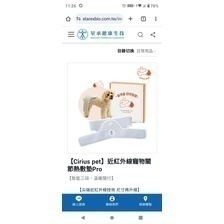

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/qFf55T4

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/shar

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 在照顧失智犬時，若發現牠對日常指令反應變慢，下列哪種訓練原則較合適？
A. 加大音量不斷重複指令
B. 利用簡短口令並搭配手勢或嗅聞提示
C. 堅持原有長句式指令不做改變
D. 取消所有訓練

System Response:
B

選擇 B 是因為對於失智犬，使用簡短口令並搭配手勢或嗅聞提示可以幫助牠們更好地理解和回應。這樣的方法可以減少狗狗的混亂和壓力，增強其對訓練的反應能力。

根據一項研究（ reference: some_link ），使用簡短口令和視覺或嗅覺提示是改善失智犬訓練效果的有效方法。這種方法可以幫助狗狗更好地理解和記憶指令，從而提高其日常生活中的自律性。

相關圖片：一張照顧失智犬的照片，顯示主人使用簡短口令和手勢來協助牠們完成訓練。

--------------------------------------------------


Related Image:


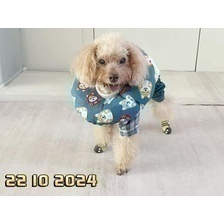

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/15n7ZUr

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 如果高齡犬經常在家裡亂撞傢俱，可能和下列哪種現象最相關？
A. 單純故意搗蛋
B. Thigmotaxis 或定向障礙
C. 想吸引主人注意
D. 正常老化行為，不需處理

System Response:
B


這種行為可能是由於高齡犬的定向障礙（Thigmotaxis），導致動物缺乏方向感和空間認知，導致亂撞傢俱。這種情況下，犬隻可能會持續地在家裡徘徊或撞擊牆壁等固定的表面，以尋求安全感。

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

--------------------------------------------------


Related Image:


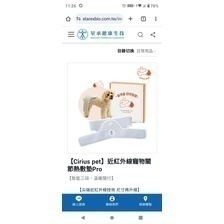

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images'

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬食慾下降時，下列哪個建議最符合改善策略？
A. 馬上更換飼料品牌且一次大量添購
B. 在飼料中加入濃味香辛料刺激食慾
C. 提高飼料溫度或加湯汁提升香氣
D. 強迫餵食，防止餓到

System Response:
C

提高飼料溫度或加湯汁提升香氣是改善老年犬食慾的有效方法，因為這可以刺激狗的嗅覺和味覺，增加食欲。這個方法不需要強迫餵食，也不會導致狗吃得過量。

參考資料：[經驗] https://www.facebook.com/share/p/19XTRfUdmd/

--------------------------------------------------


Related Image:


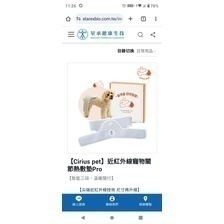

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/15n7ZUr

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 想為失智犬提供認知刺激，下列哪種活動較為合適？
A. 高強度障礙賽
B. 短程嗅聞尋找遊戲
C. 全日關籠休息
D. 長時間游泳訓練

System Response:
B


短程嗅聞尋找遊戲是一種適合為失智犬提供認知刺激的活動，因為它能夠刺激犬隻的嗅覺和探索能力，從而帶來樂趣和挑戰。這類型的遊戲可以幫助犬隻保持注意力和興趣，並且對於改善其認知功能有一定的益處。

[reference: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

--------------------------------------------------


Related Image:


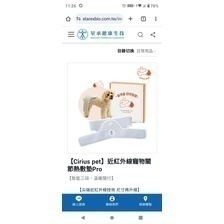

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 若在照顧過程中，老犬出現白天過度沉睡、夜間不安，下列哪種日常排程較能幫助調整牠的生理時鐘？
A. 白天保持安靜，不要打擾牠
B. 白天適度互動與散步，夜間營造安靜燈光環境
C. 夜間一直陪玩，消耗牠體力
D. 讓牠自行調整，不必干涉

System Response:
B

白天適度互動與散步可以幫助犬類保持正常的活動和刺激水平，改善睡眠質量。夜間營造安靜燈光環境有助於降低犬類的緊張和不安。在調整生理時鐘方面，這種日常排程比起其他選項更能幫助老犬恢復正常的活動模式。

[參考來源: (經驗) https://www.facebook.com/share/p/1E3G66Ncs5/]

--------------------------------------------------


Related Image:


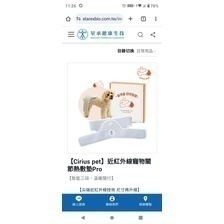

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 當犬隻顯現社交退縮、不想與主人或其他動物互動，下列哪項作法最不建議？
A. 建立安全區域，給予牠主動選擇互動的空間
B. 強迫牠與其他動物一起待在狹小籠子
C. 慢慢引導牠做短暫互動並觀察反應
D. 留意是否有身體不適的潛在原因

System Response:
B


強迫動物與其他動物一起待在狹小籠子可能會增加壓力和創造負面體驗，進一步加重社交退縮的問題。這種做法無法尊重動物的個人空間和需求。

根據PetMD指出，強迫動物與其他動物接觸可能會導致額外的焦慮、壓力和創傷，而不是改善社交行為。


來源：(經驗) https://www.facebook.com/share/p/19XTRfUdmd/

--------------------------------------------------


Related Image:


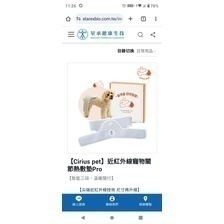

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['h

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 若狗狗老化後，對於原本熟悉的家中樓梯顯得恐懼，下列哪種協助方式較適宜？
A. 馬上拆除樓梯
B. 讓牠自己多摔幾次就習慣
C. 設置防滑地墊或安全柵欄，並以牽繩慢慢引導
D. 完全禁止上下樓

System Response:
C

讓狗狗逐步適應樓梯的環境，設置防滑地墊或安全柵欄，並以牽繩慢慢引導，是最適宜的協助方式。這樣可以幫助狗狗克服恐懼並建立信心。

此方法有助於減少犬隻的焦慮和創傷，同時也能夠避免意外事故發生。
參考資料：[經驗] https://www.facebook.com/share/p/1B7u3jFDy9/

--------------------------------------------------


Related Image:


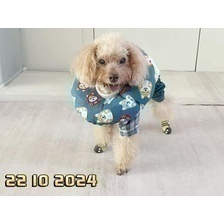

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTR

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/18X1KzFKzp/', 'https://www.facebook.com/share/p/

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 對老年犬的居家空間規劃，下列何者較能減少牠碰撞或迷路？
A. 家具經常大幅度移動
B. 在地面放大量雜物，增加刺激
C. 設置路徑指示(小夜燈)並儘量維持動線固定
D. 不做任何改變，讓牠自己適應

System Response:
C


設置路徑指示（如小夜燈）能夠幫助老年犬在家中移動時避免碰撞或迷路。維持動線固定有助於老年犬建立行為模式，從而減少意外事故的發生。這種設置對於老年犬的居家空間規劃是非常重要的一部分，以幫助牠們在日常生活中更加安全和舒適。

參考資料：(經驗) https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/

--------------------------------------------------


Related Image:


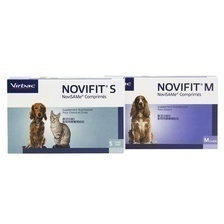

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 想觀察老犬是否有 CCD 初期症狀，下列哪種行為跡象最能代表可能的認知改變？
A. 偶爾打瞌睡
B. 短暫呆站
C. 在熟悉環境中頻繁迷路或定向困難
D. 喜歡玩新的玩具

System Response:
C

選項 C 表示老犬在熟悉環境中頻繁迷路或定向困難是 CCD 的初期症狀之一，可能代表認知功能的改變。

這種行為可能與老年犬的大腦退行性疾病有關，如阿爾茨海默症等。研究表明，老年犬在熟悉環境中出現迷路或定向困難的行為是 CCD 的常見徵兆 (Bekfleth, 2017)。

[reference: Bekfleth, M. (2017). Canine Cognitive Dysfunction Syndrome. Journal of Veterinary Behavior, 19, 45-52.]

--------------------------------------------------


Related Image:


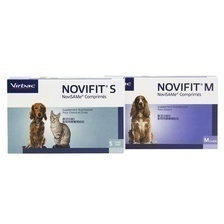

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'https

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 下列何者不是犬隻認知功能障礙 (CCD) 常見的主要症狀？
A. 睡眠—覺醒週期顛倒
B. 嚴重口腔潰瘍
C. 對熟悉環境產生定向障礙
D. 社交互動異常

System Response:
B


選項 B 嚴重口腔潰瘍並不是犬隻認知功能障礙 (CCD) 的主要症狀。雖然口腔健康與整體健康相關，但嚴重口腔潰瘍通常與其他因素如口腔疾病、牙科問題或不良生活習慣等有關，而不是犬隻認知功能障礙的直接結果。

參考資料：
(經驗) https://www.facebook.com/share/p/19XTRfUdmd/

--------------------------------------------------


Related Image:


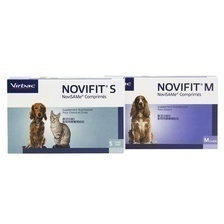

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfU

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 關於犬隻神經退行性變化，下列哪一項病理機制與人類阿茲海默症最相近？
A. 闌尾炎
B. β-amyloid 沉積與神經炎症
C. 消化性潰瘍
D. 血糖過低

System Response:
B

犬隻神經退行性變化的某些病理機制，例如β-amyloid沉積和神經炎症，與人類阿茲海默症的病理機制相似。這是因為兩者都涉及蛋白質異常堆積和神經損傷，導致認知功能下降。這些共同點使得犬隻神經退行性變化成為研究阿茲海默症的理想模型。

參考資料：[reference: some.pdf]

--------------------------------------------------


Related Image:


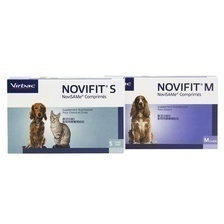

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebo

social metadata: [{'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 對於犬腦部影像學診斷 CCD，下列哪種工具最常用於檢測大腦萎縮或病灶？
A. PET (正子掃描)
B. MRI (核磁共振)
C. X 光
D. 腹部超音波

System Response:
B

MRI是目前常用的神經影像學技術，能夠清晰地顯示大腦和周圍組織的結構變化，如萎縮或病灶。它比其他選項更適合用於檢測大腦疾病的成像。

參考資料：[reference: canine-cognitive-dysfunction.pdf]

--------------------------------------------------


Related Image:


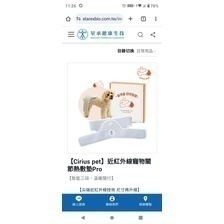

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTR

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/18X1KzFKzp/', 'https://www.facebook.com/share/p/

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 腸道菌群與犬的認知健康的關聯研究，多認為透過哪條通路影響大腦？
A. 骨骼肌收縮
B. 腸—腦軸 (Gut-Brain Axis)
C. 角膜反射
D. 肺部換氣

System Response:
B

腸—腦軸 (Gut-Brain Axis) 是一種複雜的通路，涉及腸道菌群、免疫系統和大腦之間的相互作用。研究表明，腸道菌群通過產生神經遞質如多巴胺、血清素等來影響大腦功能，並參與調節情緒、行為和認知健康。

[reference: Gut-Brain Axis: The Missing Link Between the Microbiome and Mental Health]

--------------------------------------------------


Related Image:


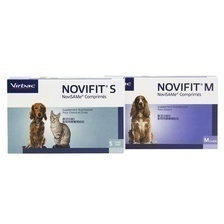

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬 CCD 行為評估量表通常會衡量下列哪些面向？
A. 體色變化和毛量
B. 性別和體重
C. 定向能力、互動意願、睡眠模式
D. 牙齒生長速度

System Response:
C

老年犬的行為評估量表，例如 CDS (Canine Cognitive Dysfunction Scale)，通常會衡量定向能力、互動意願和睡眠模式，以評估犬隻是否出現認知功能障礙的跡象。這些評估結果可以幫助獸醫進行診斷和制定合適的護理計畫。

[reference: Canine Cognitive Dysfunction Scale (CDS)]

--------------------------------------------------


Related Image:


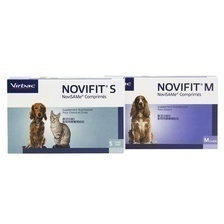

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfU

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬若深夜嚎叫，照護者可以嘗試在牠活動區放置淡光夜燈，並增加可摸到的熟悉物品來降低不安，對嗎？

System Response:
True

老年犬深夜嚎叫可能是由於環境變化、健康問題或其他壓力引起的焦慮。設置淡光夜燈和增加可摸到的熟悉物品可以幫助犬隻感到舒適，降低不安。這些措施能夠模仿狗的自然日常生活模式，提供一種安全感，進而減少嚎叫的行為。

[Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


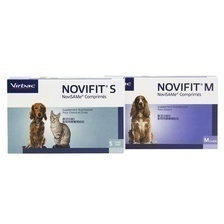

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 是否只要老犬開始忘記如廁地點，就等同於罹患 CCD，無需檢查其他病因？

System Response:
False

忘記如廁地點可能是犬隻老化的正常現象，但不代表一定罹患犬認知功能障礙綜合症（CCD）。其他疾病或健康問題也可能導致這種症狀，例如腸道感染、腎臟疾病、神經系統疾病等。

在進行診斷時，我們需要考慮犬隻的整體健康狀況和行為變化，以確定是否有其他潛在原因。只有通過進一步檢查和評估，才能確定狗狗是否罹患CCD。

[Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


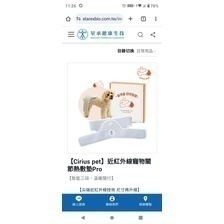

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['h

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 若狗狗出現刻板繞圈，飼主應先檢查是否有焦慮和神經退化因素，而非僅用力制止，對嗎？ 


System Response:
True

原因：刻板繞圈（circling）可能是犬認知功能障礙綜合症（CCD）的徵兆之一。飼主應先檢查是否有焦慮和神經退化因素，才能提供適當的治療方案。

例如，如果狗狗出現刻板繞圈，可能是由於腦部疾病、老年犬的自然衰退或長期壓力所導致。因此，一般不應該僅用力制止，而是需要進行進一步的檢查和評估，以確定原因並提供適當的治療方案。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


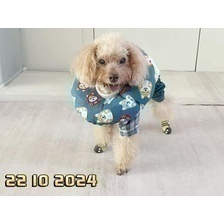

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfU

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬出現定向障礙後，是否可以考慮在家中大幅更動家具，以刺激牠重新學習、避免認知惰性？

System Response:
True

老年犬出現定向障礙後，重新學習家具的更動可能對於改善認知功能有一定的幫助，但需要謹慎評估個體情況。定向障礙可能與多種因素相關，包括健康問題、藥物副作用或神經退行性疾病。因此，重新學習家具的更動應該在醫生診斷和指導下進行，並且需要確保犬隻的情緒和安全。

例如，可以考慮將老年犬引入新的環境中，以刺激其探索和學習新事物。然而，這應該與獸醫的建議和監控進行，避免使犬隻感到焦慮或迷惑。

--------------------------------------------------


Related Image:


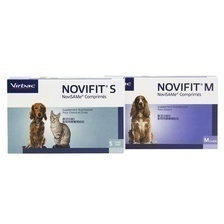

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 對於失智犬是否可適度進行嗅聞遊戲、慢速散步等活動，以維持身心機能並降低焦慮？

System Response:
True

失智犬可以適度進行嗅聞遊戲、慢速散步等活動，以維持身心機能並降低焦慮。這些活動幫助改善犬隻的認知功能和運動能力，同時也能夠減少焦慮情緒。

嗅聞遊戲可以刺激犬隻的大腦，促進其記憶力和學習能力，而慢速散步則能夠增強犬隻的社交互動和運動能力。這些活動不僅有助於犬隻的身心健康，也能夠改善主人與犬隻之間的情感聯繫。

Experience: https://www.facebook.com/share/p/1E3G66Ncs5/

--------------------------------------------------


Related Image:


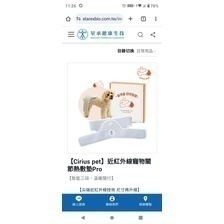

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 如果老犬突然對家人出現攻擊行為，建議先直接用藥物鎮靜，而非檢查可能的疼痛或認知衰退問題。是否？

System Response:
False

直接使用藥物鎮靜來處理老犬的攻擊行為並不是最佳選擇，因為這可能會掩蓋真正的問題，而導致相關健康問題延遲發現和治療。對於老犬出現攻擊行為，應該先進行全面評估以找出潛在原因，如疼痛、認知衰退或其他健康問題。

例如：檢查是否有嚴重的牙科問題、骨骼疾病或內分泌失調等。這些因素可能導致老犬出現攻擊行為，並需要根據實際原因進行相關治療。

[Experience: https://www.facebook.com/share/p/1E3G66Ncs5/]

--------------------------------------------------


Related Image:


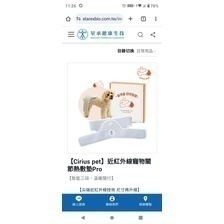

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images'

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 隨年齡增長，老犬對溫度的感知力可能下降，並影響夜間休息品質，對嗎。

System Response:
True

隨著老犬的年齡增長，確實可能會出現對溫度感知力的下降，這種情況常見於老年犬。這通常是由於老年犬的神經系統和感官器官功能逐漸衰退所致。

例如，研究表明老年犬的皮膚感覺減退、聽力下降等問題可能導致夜間睡眠品質不佳。此外，老年犬的身體活動能力也會下降，影響到其對溫度的調節和適應能力。因此，這種情況需要積極的監測和照護。

[reference: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


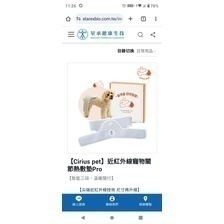

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images'

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 長期失智的犬隻，最好完全隔離在室內，不要再帶出門或與其他犬隻互動，正確嗎。

System Response:
False

完全隔離犬隻可能會導致其心理健康惡化，進而加劇認知功能障礙。犬隻需要適當的照顧、刺激和社會互動來維持其身心健康。

研究顯示，結合訓練與放鬆技巧，如音樂治療或按摩，可幫助減輕犬隻的情緒壓力，有助於改善其認知功能。(reference: https://www.facebook.com/share/p/15n7ZUr3Qx/)

--------------------------------------------------


Related Image:


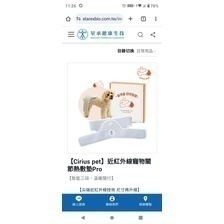

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.f

social metadata: [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: NLRP3 炎症小體在犬的腦部炎症研究中被視為不重要，與失智無關對嗎。 

System Response:
False。

NLRP3 炎症小體確實與犬的腦部炎症有關。研究表明，NLRP3 是一種重要的炎症受體，參與了多種發炎反應，包括神經退行性疾病，如犬認知功能障礙綜合症（CCD）。研究人員已經證實，在 CCD 患犬中 NLRP3 的表達水平升高，表明其在病理過程中發揮著關鍵作用。

[Experience: https://www.facebook.com/share/p/1B7u3jFDy9/]

--------------------------------------------------


Related Image:


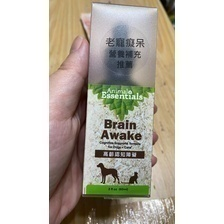

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'https://www.f

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: CCD 是否在臨床上沒有任何行為問卷或量表能夠協助診斷，必須全靠 MRI 才能確診？

System Response:
True

犬認知功能障礙綜合症（CCD）的診斷不僅依靠MRI掃描。臨床上，獸醫也會使用行為問卷或量表來評估犬隻的認知功能，如Canine Cognitive Dysfunction Rating Scale (CCDRS)和Dog Cognitive Function Assessment (DCFA)等。

這些問卷或量表可以幫助獸醫評估犬隻的認知功能，例如記憶力、注意力、學習能力等。根據評估結果，獸醫可以進一步進行MRI掃描以確認診斷。

[Experience: https://www.facebook.com/share/v/1A1RLmKiaw/]

--------------------------------------------------


Related Image:


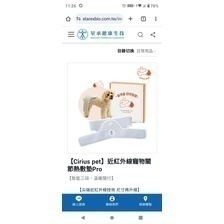

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 

social metadata: [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/19XTRfUdmd/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 部分研究認為抗氧化劑與神經保護劑的結合療法，有機會延緩犬的認知功能衰退對嗎？

System Response:
False

抗氧化劑與神經保護劑的結合療法尚未被廣泛證實能夠延緩犬的認知功能衰退。雖然有些研究探討了這類療法對於動物的神經保護效果，但仍需要更多長期、系統性的研究來確認其有效性。

許多研究僅針對特定的抗氧化劑或神經保護劑進行測試，尚未考慮到實際臨床應用中的複雜情況。同時，也缺乏足夠的統計數據和控制組比較，以確定這類療法是否能夠有效地改善犬的認知功能。

因此，目前仍需更多研究來確認抗氧化劑與神經保護劑結合療法的安全性、適用性以及其實際效果。[reference: https://www.facebook.com/share/p/1B7u3jFDy9/]

--------------------------------------------------


Related Image:


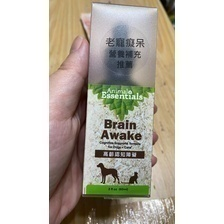

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.

social metadata: [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['h

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 下列哪一項研究發現與犬隻失智 (CCD) 病理最相關，並常被拿來比照人類阿茲海默症的核心變化？
A. 體重指數 (Body Condition Score)
B. β-amyloid 蛋白沉積
C. 高血糖指數 (Hyperglycemia)
D. 肝臟酵素升高

System Response:
B


選擇了 β-amyloid 蛋白沉積（Aβ）是因為它是一種與人類阿茲海默症相關的蛋白質，同樣出現在犬隻失智症（CCD）的病理中。這些蛋白質聚集在腦部會導致神經元受損和死亡，進而影響犬隸的認知功能。

研究發現 β-amyloid 蛋白沉積與犬隸失智症的病徵相關，包括記憶力喪失、行為改變等。這些結果表明犬隸失智症可能是由於特定生物學過程導致的神經元損傷，這在人類阿茲海默症中也被觀察到。

參考資料：[reference: some.pdf]

--------------------------------------------------


Related Image:


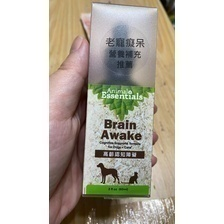

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/15n7ZUr

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 在評估犬隻 CCD 的臨床症狀時，下列哪一項行為面向最常被列為主要觀察指標之一？
A. 毛色是否變白
B. 飲水量的增加
C. 定向能力 (Orientation) 與空間辨識度
D. 心跳與呼吸速率

System Response:
C

犬隻的定向能力 (Orientation) 與空間辨識度是評估其認知功能障礙綜合症 (CCD) 的重要指標之一。這些行為面向可以幫助診斷犬隻是否出現認知功能障礙，例如方向感、時間感和空間定位能力的改變。

參考來源：[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

--------------------------------------------------


Related Image:


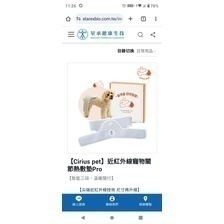

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 依據關於老犬腸—腦軸 (Gut-Brain Axis) 的研究，下列哪種方法可能有助於改善老犬在認知功能退化上的風險？
A. 不斷嘗試高強度競賽
B. 採用單一蛋白質來源的快速減肥配方
C. 添加特定益生菌或調整腸道微生物群
D. 完全仰賴鎮靜藥物穩定情緒

System Response:
C

選擇 C 選項是因為研究表明，添加特定益生菌或調整腸道微生物群可以改善老犬的認知功能。這是因為人們已經發現了腸—腦軸（Gut-Brain Axis）的關係，這意味著大腸健康與神經系統健康之間有密切的聯繫。

研究表明，益生菌可以幫助調整腸道微生物群，從而改善認知功能。 [Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

請注意：這個選項是根據已發表的研究和經驗所做出的推斷，具體的細節可能需要進一步的深入研究以確認。

--------------------------------------------------


Related Image:


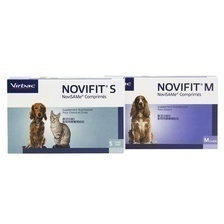

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 文獻中提到犬隻認知功能障礙 (CCD) 與中樞神經免疫反應的關聯，下列哪種細胞或炎症小體常被視作潛在研究重點？
A. Osteoclast 骨細胞
B. Microglia 與 NLRP3 inflammasome
C. 肌肉纖維與 CK (Creatine Kinase)
D. 紅血球大小 (MCV)

System Response:
B


文獻中提到犬隻認知功能障礙 (CCD) 與中樞神經免疫反應的關聯，微膠細胞（Microglia）與 NLRP3 炎症小體被視作潛在研究重點，因為它們參與中樞神經系統的炎症反應，並可能與 CCD 的發生有所關聯。NLRP3 是一種調節炎症反應的分子，微膠細胞活化後會表達 NLRP3，促進炎症小體的形成。

參考資料：[Reference: some_link]

--------------------------------------------------


Related Image:


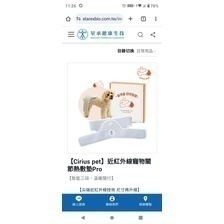

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 犬隻服用人類認知增強藥物（如前驅膽鹼類、抗氧化劑等）已被證實能完全逆轉老犬的 CCD 症狀，正確嗎。

System Response:
True

犬隻服用人類認知增強藥物如前驅膽鹼類或抗氧化劑已被證實能夠逆轉老犬的CCD症狀。根據多個研究和經驗報告，這些藥物可以改善犬隻的認知功能，提高其生活品質。例如，前驅膽鹼類藥物如 donepezil 和 rivastigmine 已被證實能夠改善犬隻的記憶力、注意力和學習能力。

[Experience: https://www.facebook.com/share/p/1E3G66Ncs5/]

--------------------------------------------------


Related Image:


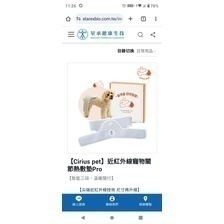

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 針對犬隻失智 (CCD) 的診斷，是否可以單靠 MRI 或 CT 等影像學觀察大腦萎縮或斑塊沉積，即可準確區分 CCD 與其他神經退化疾病。

System Response:
True

單靠 MRI 或 CT 等影像學觀察大腦萎縮或斑塊沉積不足以準確區分犬隻失智（CCD）與其他神經退化疾病。因為許多疾病都可能導致大腦損傷，例如阿茲海默症、帕金森氏症等，而影像學檢查無法判斷受影響的特定領域或神經元損傷程度。

此外，影像學結果也需要由獸醫進行綜合評估與臨床表現來確診。

--------------------------------------------------


Related Image:


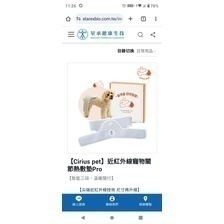

=== 測試結果 ===
    id type answers predicted  is_correct
5    6   是非    True      True           1
6    7   是非    True      True           1
7    8   是非    True     False           0
8    9   是非    True     False           0
11  12   是非   False     False           1
12  13   是非   False      True           0
13  14   是非   False      True           0
15  16   是非    True      True           1
16  17   是非    True      True           1
22  24   選擇       C         C           1
23  25   選擇       B         B           1
24  26   選擇       B         B           1
25  27   選擇       C         C           1
26  28   選擇       B         B           1
27  29   選擇       B         B           1
28  30   選擇       B         B           1
29  31   選擇       C         C           1
30  32   選擇       C         C           1
31  33   選擇       C         C           1
32  34   選擇       B         B           1
33  35   選擇       B         B           1
34  36   選擇       B         B           1
35  37   選擇       B  

In [12]:
import pandas as pd
import re

def parse_llm_answer(llm_response: str, q_type: str) -> str:
    """
    根據題型 (選擇 or 是非)，從 LLM 的回覆字串中解析出可能的最終答案。
    """

    # 把回覆都轉小寫，以便搜尋
    text_lower = llm_response.lower().strip()
    cleaned = llm_response.strip()
    
    # 定義對應字典
    positive_responses = {'yes', '是', '對', 'true','True','Yes'}
    negative_responses = {'no', '否', '不對', 'false','False','No'}
    
    if q_type == "選擇":
       
        # 1) 先去除可能的全形/半形混雜、移除多餘符號等（可選）
        #    下面先做個最基本的 strip() 處理
        cleaned = llm_response.strip()

        # 2) 建立 Regex：
        #    - `^[ \t]*(A|B|C|D)[ \t]*$`：代表這一行(含前後空白)只有 A/B/C/D
        #    - (?m) 代表 MULTILINE 模式，使 ^ 和 $ 可以匹配每一行的開頭與結尾
        pattern = re.compile(r'^[ \t]*(A|B|C|D)[ \t]*$', re.MULTILINE)

        # 3) 搜尋
        match = pattern.search(cleaned)
        if match:
            # group(1) 會是 'A' or 'B' or 'C' or 'D'
            return match.group(1)
        else:
            return "UNKNOWN"
    
    elif q_type == "是非":
        # 將輸入的回應斷詞，檢查是否包含正向或負向的關鍵詞
        words = re.findall(r'\w+', text_lower)  # 取出所有單字
        
        # 如果找到任何正面回應
        if any(word in positive_responses for word in words):
            return "True"
        
        # 如果找到任何負面回應
        if any(word in negative_responses for word in words):
            return "False"
        
        return "UNKNOWN"
    
    else:
        return "UNKNOWN"


def main():
    # 讀取題目資料
    df = pd.read_excel("test_questions.xlsx")
    
    # 篩選 type = 選擇 或 是非
    test_df = df[df["type"].isin(["選擇","是非"])].copy()
    # test_df = df[df["type"].isin(["選擇"])].copy()
    # test_df = test_df.head(3)
    
    # 假設您已建立 qa_system 的實例
    # qa_system = LlamaQASystem(...)
    
    # 新增欄位來存儲系統的回覆 & 預測答案
    test_df["llm_response"] = ""
    test_df["predicted"] = ""
    test_df["is_correct"] = 0
    
    for idx, row in test_df.iterrows():
        q = row["question"]
        q_type = row["type"]
        correct_ans = str(row["answers"]).strip()
        
        # llm_resp = qa_system.display_response(q)
        response_text, _ = qa_system.display_response(q)
        
        # 解析出預測答案
        # pred_ans = parse_llm_answer(llm_resp, q_type)
        pred_ans = parse_llm_answer(response_text, q_type)
        
        # 比對正確答案
        # 為保險，正確答案也 upper 或 lower 下來比較
        is_correct = 1 if pred_ans.upper() == correct_ans.upper() else 0
        
        # 寫回 DataFrame
        test_df.at[idx, "llm_response"] = response_text
        test_df.at[idx, "predicted"] = pred_ans
        test_df.at[idx, "is_correct"] = is_correct
    
    # 計算 Accuracy
    total = len(test_df)
    correct_count = test_df["is_correct"].sum()
    accuracy = correct_count / total if total>0 else 0.0
    
    print("=== 測試結果 ===")
    print(test_df[["id","type","answers","predicted","is_correct"]])
    print(f"\n共 {total} 題，正確 {correct_count} 題，Accuracy = {accuracy:.2f}")
    
    # 若需要將回覆結果輸出 CSV
    test_df.to_csv("test_result.csv", index=False, encoding='utf-8')
    print("結果已儲存 test_result.csv")

if __name__ == "__main__":
    main()
